In [1]:
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
import pickle
from tqdm import tqdm
import onnx
import onnxruntime
import os
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import cm

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

SystemError: <built-in function __import__> returned a result with an error set

#### SphereFace

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import Parameter
import math

def myphi(x,m):
    x = x * m
    return 1-x**2/math.factorial(2)+x**4/math.factorial(4)-x**6/math.factorial(6) + \
            x**8/math.factorial(8) - x**9/math.factorial(9)

class AngleLinear(nn.Module):
    def __init__(self, in_features, out_features, m = 4, phiflag=True):
        super(AngleLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features,out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.phiflag = phiflag
        self.m = m
        self.mlambda = [
            lambda x: x**0,
            lambda x: x**1,
            lambda x: 2*x**2-1,
            lambda x: 4*x**3-3*x,
            lambda x: 8*x**4-8*x**2+1,
            lambda x: 16*x**5-20*x**3+5*x
        ]

    def forward(self, input):
        x = input   # size=(B,F)    F is feature len
        w = self.weight # size=(F,Classnum) F=in_features Classnum=out_features

        ww = w.renorm(2,1,1e-5).mul(1e5)
        xlen = x.pow(2).sum(1).pow(0.5) # size=B
        wlen = ww.pow(2).sum(0).pow(0.5) # size=Classnum

        cos_theta = x.mm(ww) # size=(B,Classnum)
        cos_theta = cos_theta / xlen.view(-1,1) / wlen.view(1,-1)
        cos_theta = cos_theta.clamp(-1,1)

        if self.phiflag:
            cos_m_theta = self.mlambda[self.m](cos_theta)
            theta = Variable(cos_theta.data.acos())
            k = (self.m*theta/3.14159265).floor()
            n_one = k*0.0 - 1
            phi_theta = (n_one**k) * cos_m_theta - 2*k
        else:
            theta = cos_theta.acos()
            phi_theta = myphi(theta,self.m)
            phi_theta = phi_theta.clamp(-1*self.m,1)

        cos_theta = cos_theta * xlen.view(-1,1)
        phi_theta = phi_theta * xlen.view(-1,1)
        output = (cos_theta,phi_theta)
        return output # size=(B,Classnum,2)


class AngleLoss(nn.Module):
    def __init__(self, gamma=0):
        super(AngleLoss, self).__init__()
        self.gamma   = gamma
        self.it = 0
        self.LambdaMin = 5.0
        self.LambdaMax = 1500.0
        self.lamb = 1500.0

    def forward(self, input, target):
        self.it += 1
        cos_theta,phi_theta = input
        target = target.view(-1,1) #size=(B,1)

        index = cos_theta.data * 0.0 #size=(B,Classnum)
        index.scatter_(1,target.data.view(-1,1),1)
        index = index.byte()
        index = Variable(index)

        self.lamb = max(self.LambdaMin,self.LambdaMax/(1+0.1*self.it ))
        output = cos_theta * 1.0 #size=(B,Classnum)
        output[index] -= cos_theta[index]*(1.0+0)/(1+self.lamb)
        output[index] += phi_theta[index]*(1.0+0)/(1+self.lamb)

        logpt = F.log_softmax(output)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        loss = -1 * (1-pt)**self.gamma * logpt
        loss = loss.mean()

        return loss


class sphere(nn.Module):
    def __init__(self,classnum=10574,feature=False):
        super(sphere, self).__init__()
        self.classnum = classnum
        self.feature = feature
        #input = B*3*112*96
        self.conv1_1 = nn.Conv2d(3,64,3,2,1) #=>B*64*56*48
        self.relu1_1 = nn.PReLU(64)
        self.conv1_2 = nn.Conv2d(64,64,3,1,1)
        self.relu1_2 = nn.PReLU(64)
        self.conv1_3 = nn.Conv2d(64,64,3,1,1)
        self.relu1_3 = nn.PReLU(64)

        self.conv2_1 = nn.Conv2d(64,128,3,2,1) #=>B*128*28*24
        self.relu2_1 = nn.PReLU(128)
        self.conv2_2 = nn.Conv2d(128,128,3,1,1)
        self.relu2_2 = nn.PReLU(128)
        self.conv2_3 = nn.Conv2d(128,128,3,1,1)
        self.relu2_3 = nn.PReLU(128)

        self.conv2_4 = nn.Conv2d(128,128,3,1,1) #=>B*128*28*24
        self.relu2_4 = nn.PReLU(128)
        self.conv2_5 = nn.Conv2d(128,128,3,1,1)
        self.relu2_5 = nn.PReLU(128)


        self.conv3_1 = nn.Conv2d(128,256,3,2,1) #=>B*256*14*12
        self.relu3_1 = nn.PReLU(256)
        self.conv3_2 = nn.Conv2d(256,256,3,1,1)
        self.relu3_2 = nn.PReLU(256)
        self.conv3_3 = nn.Conv2d(256,256,3,1,1)
        self.relu3_3 = nn.PReLU(256)

        self.conv3_4 = nn.Conv2d(256,256,3,1,1) #=>B*256*14*12
        self.relu3_4 = nn.PReLU(256)
        self.conv3_5 = nn.Conv2d(256,256,3,1,1)
        self.relu3_5 = nn.PReLU(256)

        self.conv3_6 = nn.Conv2d(256,256,3,1,1) #=>B*256*14*12
        self.relu3_6 = nn.PReLU(256)
        self.conv3_7 = nn.Conv2d(256,256,3,1,1)
        self.relu3_7 = nn.PReLU(256)

        self.conv3_8 = nn.Conv2d(256,256,3,1,1) #=>B*256*14*12
        self.relu3_8 = nn.PReLU(256)
        self.conv3_9 = nn.Conv2d(256,256,3,1,1)
        self.relu3_9 = nn.PReLU(256)

        self.conv4_1 = nn.Conv2d(256,512,3,2,1) #=>B*512*7*6
        self.relu4_1 = nn.PReLU(512)
        self.conv4_2 = nn.Conv2d(512,512,3,1,1)
        self.relu4_2 = nn.PReLU(512)
        self.conv4_3 = nn.Conv2d(512,512,3,1,1)
        self.relu4_3 = nn.PReLU(512)

        self.fc5 = nn.Linear(512*7*6,512)
        self.fc6 = AngleLinear(512,self.classnum)


    def forward(self, x):
        x = self.relu1_1(self.conv1_1(x))
        x = x + self.relu1_3(self.conv1_3(self.relu1_2(self.conv1_2(x))))

        x = self.relu2_1(self.conv2_1(x))
        x = x + self.relu2_3(self.conv2_3(self.relu2_2(self.conv2_2(x))))
        x = x + self.relu2_5(self.conv2_5(self.relu2_4(self.conv2_4(x))))

        x = self.relu3_1(self.conv3_1(x))
        x = x + self.relu3_3(self.conv3_3(self.relu3_2(self.conv3_2(x))))
        x = x + self.relu3_5(self.conv3_5(self.relu3_4(self.conv3_4(x))))
        x = x + self.relu3_7(self.conv3_7(self.relu3_6(self.conv3_6(x))))
        x = x + self.relu3_9(self.conv3_9(self.relu3_8(self.conv3_8(x))))

        x = self.relu4_1(self.conv4_1(x))
        x = x + self.relu4_3(self.conv4_3(self.relu4_2(self.conv4_2(x))))

        x = x.view(x.size(0),-1)
        x = self.fc5(x)
        if self.feature: return x

        x = self.fc6(x)
        return x


### Utilities

In [4]:
def performance(f):
    def fn(*args, **kw):
        t1 = time.time()
        r = f(*args, **kw)
        t2 = time.time()
        print('call {} in {}s'.format(f.__name__, (t2-t1)))
        return r
    return fn


@performance
def generate_images_classes(path):
    classes = os.listdir(path)
    celeb_dict = OrderedDict()
    for celeb in classes:
        celeb_dict[celeb] = os.listdir(path+celeb+'/')
    return celeb_dict


def compute_cos_sim(emb1, emb2):
    sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    return sim


@performance
def calculate_rec_acc(X, y, mean_X, mean_y):
    correct = 0
    total = len(X)
    for i in tqdm(range(len(X))):
        max_sim = -1
        max_index = -1
        for j in range(len(mean_X)):
            sim = compute_cos_sim(X[i], mean_X[j])
            if sim > max_sim:
                max_sim = sim
                max_index = j
        if mean_y[max_index] == y[i]:
            correct += 1
    return correct/total


@performance
def generate_image_embeddings(model, celeb_dict):
    handler = insightface.model_zoo.get_model(model,
                                              providers=['CPUExecutionProvider'])
    handler.prepare(ctx_id=0)
    embedding_dict = OrderedDict()
    image_dict = {}
    for celeb, imgs in tqdm(celeb_dict.items()):
        if celeb not in embedding_dict:
            embedding_dict[celeb] = []
            image_dict[celeb] = []
        for img in imgs:
            img_path = aligned_pins + celeb + '/' + img
            image = cv2.imread(img_path)
            try:
                face_embedding = handler.get(image)
            except:
                continue
            embedding_dict[celeb].append(face_embedding)
            image_dict[celeb].append((img, face_embedding))
    return embedding_dict, image_dict


@performance
def generate_image_embeddings_cuda(model, celeb_dict):
    handler = insightface.model_zoo.get_model(model,
                                              providers=['CUDAExecutionProvider'])
    handler.prepare(ctx_id=0)
    embedding_dict = OrderedDict()
    image_dict = {}
    for celeb, imgs in tqdm(celeb_dict.items()):
        if celeb not in embedding_dict:
            embedding_dict[celeb] = []
            image_dict[celeb] = []
        for img in imgs:
            img_path = aligned_pins + celeb + '/' + img
            image = cv2.imread(img_path)
            try:
                face_embedding = handler.get(image)
            except:
                continue
            embedding_dict[celeb].append(face_embedding)
            image_dict[celeb].append((img, face_embedding))
    return embedding_dict, image_dict

def sphere_generate_image_embeddings(model, celeb_dict):
    # model.to('cuda')
    model.eval()
    with torch.no_grad():
        embedding_dict = OrderedDict()
        image_dict = {}
        for celeb, imgs in tqdm(celeb_dict.items()):
            if celeb not in embedding_dict:
                embedding_dict[celeb] = []
                image_dict[celeb] = []
            for img in imgs:
                img_path = aligned_pins + celeb + '/' + img
                image = cv2.imread(img_path)
#                 h, w = image.shape[:2]
#                 pad_bottom, pad_right = 0, 0
#                 ratio = w / h

#                 if h > 112 or w > 96:
#                     # shrinking image algorithm
#                     interp = cv2.INTER_AREA
#                 else:
#                     # stretching image algorithm
#                     interp = cv2.INTER_CUBIC

#                 w = 96
#                 h = round(w / ratio)
#                 if h > 112:
#                     h = 112
#                     w = round(h * ratio)
#                 pad_bottom = abs(112 - h)
#                 pad_right = abs(96 - w)

#                 scaled_img = cv2.resize(image, (w, h), interpolation=interp)
#                 image = cv2.copyMakeBorder(
#                     scaled_img,0,pad_bottom,0,pad_right,borderType=cv2.BORDER_CONSTANT,value=[0,0,0])

#                 plt.imshow(image)
#                 plt.show()
#                 break
                image = cv2.resize(image,(96,112))
                image = image.astype(np.float32, copy=False)
                image -= 127.5
                image /= 127.5
                tensor = np.zeros((3,112,96))
                tensor[0] = image[:,:,0]
                tensor[1] = image[:,:,1]
                tensor[2] = image[:,:,2]
                image = torch.tensor(tensor).unsqueeze(0).float()
                # image = image.to('cuda')
                face_embedding = model(image)
                embedding_dict[celeb].append(face_embedding.cpu().squeeze().numpy())
                image_dict[celeb].append((img, face_embedding))
        return embedding_dict, image_dict


@performance
def calculate_mean_embeddings(emb_dict):
    mean_emb_dict = OrderedDict()

    for key in emb_dict:
        n = len(emb_dict[key])
        emb_sum = np.sum(emb_dict[key], axis=0)
        mean_emb = emb_sum / n
        mean_emb_dict[key] = mean_emb

    return mean_emb_dict

### Prepare models

In [5]:
models = ['w600k_mbf.onnx', 'w600k_r50.onnx', 'glintr100.onnx']
pins = './research_data/105_classes_pins_dataset/'
aligned_pins = './research_data/aligned_pins_dataset/'
emb_save_path = './embeddings/'
if not os.path.isdir(emb_save_path):
    os.makedirs(emb_save_path)
celeb_dict = generate_images_classes(aligned_pins)
ori_celeb_dict = generate_images_classes(pins)

call generate_images_classes in 0.02001214027404785s
call generate_images_classes in 0.018992900848388672s


In [28]:
net = sphere(feature=True)
net.load_state_dict(torch.load('./sphereface/model/sphere.pth'))

<All keys matched successfully>

### Generate Sphereface embddings

In [29]:
model = 'sphereface'
embedding_dict, image_dict = sphere_generate_image_embeddings(net, celeb_dict)
# save image embeddings
save_path = emb_save_path + model + '_aligned_emb_dict.pkl'
f_write = open(save_path, 'wb')
pickle.dump(embedding_dict, f_write)
f_write.close()
# test reading image embeddings
f_read = open(save_path, 'rb')
emb_dict = pickle.load(f_read)
f_read.close()

# save image embeddings
save_path = emb_save_path + model + '_aligned_img_dict.pkl'
f_write = open(save_path, 'wb')
pickle.dump(image_dict, f_write)
f_write.close()

mean_emb_dict = calculate_mean_embeddings(emb_dict)
save_path = emb_save_path + model + '_aligned_mean_emb_dict.pkl'

f_write = open(save_path, 'wb')
pickle.dump(mean_emb_dict, f_write)
f_write.close()

f_read = open(save_path, 'rb')
mean_emb_dict = pickle.load(f_read)
f_read.close()

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [07:05<00:00,  4.06s/it]


call calculate_mean_embeddings in 0.014995098114013672s


### Test Sphere

In [30]:
with open(emb_save_path+'sphereface_aligned_emb_dict.pkl', 'rb') as f:
    emb_dict = pickle.load(f)

X = []
ori_y = []
y = []

for celeb in emb_dict:
    embs = emb_dict[celeb]
    for emb in embs:
        X.append(emb)
        ori_y.append(celeb)

le = LabelEncoder()
y = le.fit_transform(ori_y)
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

17530


In [31]:
train_dict = OrderedDict()

for i in range(len(y_train)):
    if y_train[i] not in train_dict:
        train_dict[y_train[i]] = []
    train_dict[y_train[i]].append(X_train[i])

train_mean_emb = calculate_mean_embeddings(train_dict)
rec_acc = calculate_rec_acc(X_test, y_test, list(train_mean_emb.values()), list(train_mean_emb.keys()))
print(rec_acc)
# acc_dict['sphereface'] = rec_acc

call calculate_mean_embeddings in 0.014992713928222656s


100%|█████████████████████████████████████████████████████████████████████████████| 3506/3506 [00:04<00:00, 848.57it/s]

call calculate_rec_acc in 4.1356141567230225s
0.8394181403308614


### Impact of Face Alignment

In [6]:
model = 'w600k_mbf.onnx'

#### original

In [8]:
aligned_pins = './research_data/105_classes_pins_dataset/'
embedding_dict, image_dict = generate_image_embeddings_cuda(model, ori_celeb_dict)
# save image embeddings
save_path = emb_save_path + model + 'ori_emb_dict.pkl'
f_write = open(save_path, 'wb')
pickle.dump(embedding_dict, f_write)
f_write.close()
# test reading image embeddings
f_read = open(save_path, 'rb')
emb_dict = pickle.load(f_read)
f_read.close()

# save image embeddings
save_path = emb_save_path + model + 'ori_img_dict.pkl'
f_write = open(save_path, 'wb')
pickle.dump(image_dict, f_write)
f_write.close()

mean_emb_dict = calculate_mean_embeddings(emb_dict)
save_path = emb_save_path + model + 'ori_mean_emb_dict.pkl'

f_write = open(save_path, 'wb')
pickle.dump(mean_emb_dict, f_write)
f_write.close()

f_read = open(save_path, 'rb')
mean_emb_dict = pickle.load(f_read)
f_read.close()

X = []
ori_y = []
y = []

for celeb in emb_dict:
    embs = emb_dict[celeb]
    for emb in embs:
        X.append(emb)
        ori_y.append(celeb)

le = LabelEncoder()
y = le.fit_transform(ori_y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

train_dict = OrderedDict()

for i in range(len(y_train)):
    if y_train[i] not in train_dict:
        train_dict[y_train[i]] = []
    train_dict[y_train[i]].append(X_train[i])

train_mean_emb = calculate_mean_embeddings(train_dict)
rec_acc = calculate_rec_acc(X_test, y_test, list(train_mean_emb.values()), list(train_mean_emb.keys()))
print(rec_acc)
# acc_dict['r50'] = rec_acc

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_use_max_workspace': '0'}, 'CPUExecutionProvider': {}}


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:54<00:00,  1.94it/s]


call generate_image_embeddings_cuda in 54.26469111442566s
call calculate_mean_embeddings in 0.01497793197631836s
call calculate_mean_embeddings in 0.015989303588867188s


100%|█████████████████████████████████████████████████████████████████████████████| 3507/3507 [00:04<00:00, 843.50it/s]

call calculate_rec_acc in 4.162592887878418s
0.9560878243512974


#### Detected

In [12]:
aligned_pins = './research_data/dbface_detected/'
embedding_dict, image_dict = generate_image_embeddings_cuda(model, celeb_dict)
# save image embeddings
save_path = emb_save_path + model + 'det_emb_dict.pkl'
f_write = open(save_path, 'wb')
pickle.dump(embedding_dict, f_write)
f_write.close()
# test reading image embeddings
f_read = open(save_path, 'rb')
emb_dict = pickle.load(f_read)
f_read.close()

# save image embeddings
save_path = emb_save_path + model + 'det_img_dict.pkl'
f_write = open(save_path, 'wb')
pickle.dump(image_dict, f_write)
f_write.close()

mean_emb_dict = calculate_mean_embeddings(emb_dict)
save_path = emb_save_path + model + 'det_mean_emb_dict.pkl'

f_write = open(save_path, 'wb')
pickle.dump(mean_emb_dict, f_write)
f_write.close()

f_read = open(save_path, 'rb')
mean_emb_dict = pickle.load(f_read)
f_read.close()

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_use_max_workspace': '0'}, 'CPUExecutionProvider': {}}


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [01:43<00:00,  1.01it/s]


call generate_image_embeddings_cuda in 105.96103596687317s
call calculate_mean_embeddings in 0.0159912109375s


In [13]:
with open(emb_save_path+'w600k_mbf.onnxdet_emb_dict.pkl', 'rb') as f:
    emb_dict = pickle.load(f)

X = []
ori_y = []
y = []

for celeb in emb_dict:
    embs = emb_dict[celeb]
    for emb in embs:
        X.append(emb)
        ori_y.append(celeb)

le = LabelEncoder()
y = le.fit_transform(ori_y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

train_dict = OrderedDict()

for i in range(len(y_train)):
    if y_train[i] not in train_dict:
        train_dict[y_train[i]] = []
    train_dict[y_train[i]].append(X_train[i])

train_mean_emb = calculate_mean_embeddings(train_dict)
rec_acc = calculate_rec_acc(X_test, y_test, list(train_mean_emb.values()), list(train_mean_emb.keys()))
print(rec_acc)

call calculate_mean_embeddings in 0.016991138458251953s


100%|█████████████████████████████████████████████████████████████████████████████| 3506/3506 [00:05<00:00, 663.51it/s]

call calculate_rec_acc in 5.286979913711548s
0.8904734740444952


### Generate Arcface embddings

In [6]:
aligned_pins = './research_data/aligned_pins_dataset/'
for model in models:
    embedding_dict, image_dict = generate_image_embeddings(model, celeb_dict)
    # save image embeddings
#     save_path = emb_save_path + model + '_aligned_emb_dict.pkl'
#     f_write = open(save_path, 'wb')
#     pickle.dump(embedding_dict, f_write)
#     f_write.close()
#     # test reading image embeddings
#     f_read = open(save_path, 'rb')
#     emb_dict = pickle.load(f_read)
#     f_read.close()

#     # save image embeddings
#     save_path = emb_save_path + model + '_aligned_img_dict.pkl'
#     f_write = open(save_path, 'wb')
#     pickle.dump(image_dict, f_write)
#     f_write.close()

#     mean_emb_dict = calculate_mean_embeddings(emb_dict)
#     save_path = emb_save_path + model + '_aligned_mean_emb_dict.pkl'

#     f_write = open(save_path, 'wb')
#     pickle.dump(mean_emb_dict, f_write)
#     f_write.close()

#     f_read = open(save_path, 'rb')
#     mean_emb_dict = pickle.load(f_read)
#     f_read.close()

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [04:04<00:00,  2.33s/it]


call generate_image_embeddings in 245.24570536613464s
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [19:18<00:00, 11.04s/it]


call generate_image_embeddings in 1160.6035301685333s
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [2:06:33<00:00, 72.32s/it]

call generate_image_embeddings in 7596.079213619232s


In [7]:
acc_dict = {}

### test r50

In [6]:
with open(emb_save_path+'w600k_r50.onnx_aligned_emb_dict.pkl', 'rb') as f:
    emb_dict = pickle.load(f)

X = []
ori_y = []
y = []

for celeb in emb_dict:
    embs = emb_dict[celeb]
    for emb in embs:
        X.append(emb)
        ori_y.append(celeb)

le = LabelEncoder()
y = le.fit_transform(ori_y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

#### Visualization

C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


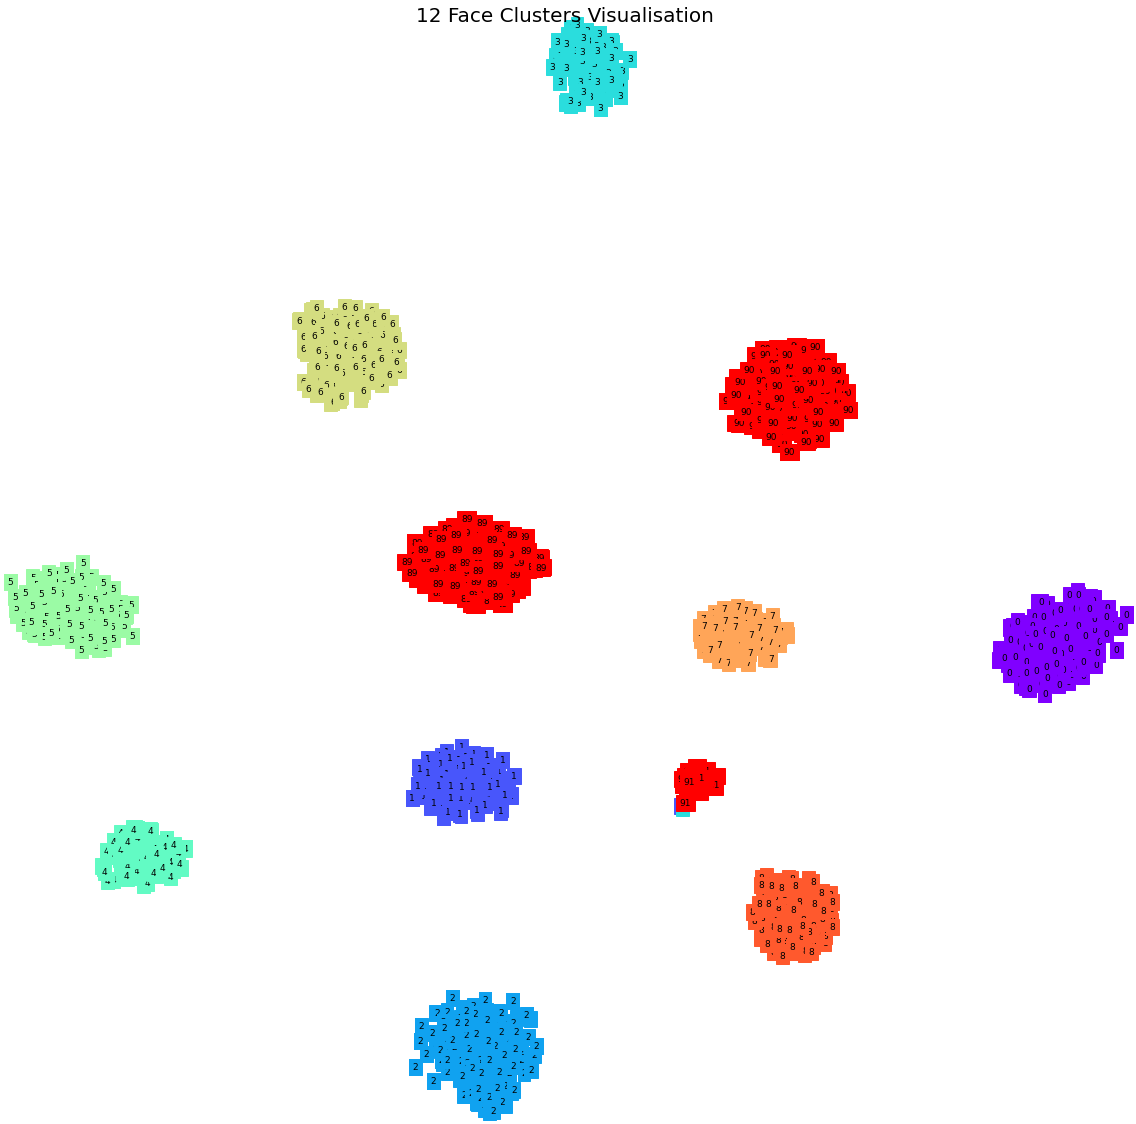

In [10]:
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.axis('off')
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('12 Face Clusters Visualisation',fontsize=20); plt.show(); plt.pause(0.01)

plt.rcParams['figure.figsize'] = (20,20)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=100)
plot_only = 2000
low_dim_embs = tsne.fit_transform(X[:plot_only])
labels = y[:plot_only]
plot_with_labels(low_dim_embs, labels)

In [17]:
print('train size: {}\ntest size: {}'.format(len(X_train), len(X_test)))

train size: 14024
test size: 3506


In [18]:
np.array(X_train).shape

(14024, 512)

#### KNN with Euclidean

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [02:39<00:00,  1.66s/it]


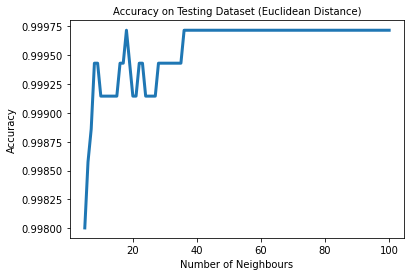

In [7]:
from sklearn.metrics import accuracy_score
n = []
acc = []
for i in tqdm(range(5,101)):
    n.append(i)
    knn = KNN(n_neighbors=i,algorithm='brute')
    knn.fit(X_train,y_train)
    predictions = knn.predict(X_test)
    acc.append(accuracy_score(predictions,y_test))

plt.plot(n,acc,lw=3)
plt.xlabel('Number of Neighbours',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
# plt.legend(loc='best', fontsize=30)
plt.title('Accuracy on Testing Dataset (Euclidean Distance)',fontsize=10)
plt.show()

In [20]:
max_score = max(acc)
max_n = n[np.argmax(np.array(acc))]

In [21]:
print('max accuracy is {} with {} neighbours'.format(max_score,max_n))

max accuracy is 0.9997147746719909 with 18 neighbours


In [22]:
print('max neighbors')
for i in range(len(acc)):
    if acc[i] == max_score:
        print(n[i])

max neighbors
18
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


#### KNN with cosine distance

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [01:55<00:00,  1.21s/it]


Text(0.5, 1.0, 'Accuracy on Testing Dataset (Cosine Distance)')

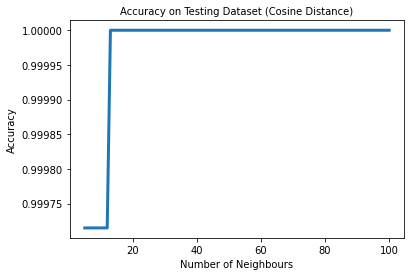

In [8]:
n = []
acc = []
X_train = normalize(X_train)
X_test = normalize(X_test)
for i in tqdm(range(5,101)):
    n.append(i)
    knn = KNN(n_neighbors=i,algorithm='brute')
    knn.fit(X_train,y_train)
    predictions = knn.predict(X_test)
    acc.append(accuracy_score(predictions,y_test))

plt.plot(n,acc,lw=3)
plt.xlabel('Number of Neighbours',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
# plt.legend(loc='best', fontsize=30)
plt.title('Accuracy on Testing Dataset (Cosine Distance)',fontsize=10)

In [24]:
max_score = max(acc)
max_n = n[np.argmax(np.array(acc))]

In [25]:
print('max accuracy is {} with {} neighbours'.format(max_score,max_n))

max accuracy is 1.0 with 13 neighbours


In [26]:
print('max neighbors')
for i in range(len(acc)):
    if acc[i] == max_score:
        print(n[i])

max neighbors
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


#### Mean Cosine Similarity

In [27]:
train_dict = OrderedDict()

for i in range(len(y_train)):
    if y_train[i] not in train_dict:
        train_dict[y_train[i]] = []
    train_dict[y_train[i]].append(X_train[i])

train_mean_emb = calculate_mean_embeddings(train_dict)
rec_acc = calculate_rec_acc(X_test, y_test, list(train_mean_emb.values()), list(train_mean_emb.keys()))
print(rec_acc)
# acc_dict['r50'] = rec_acc

call calculate_mean_embeddings in 0.027013301849365234s


100%|█████████████████████████████████████████████████████████████████████████████| 3506/3506 [00:04<00:00, 808.29it/s]

call calculate_rec_acc in 4.341520309448242s
1.0


In [24]:
means = np.array(list(train_mean_emb.values())).reshape((105,-1))

In [25]:
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=105, random_state=42, means_init=means)
gmm.fit(X_train)

GaussianMixture(means_init=array([[-0.528693  , -0.9543298 ,  0.8392538 , ..., -1.0304028 ,
        -0.41887024, -0.24469292],
       [ 0.06803945,  0.38304752,  0.02873698, ...,  0.32107487,
         0.35550013,  0.25613979],
       [-0.84135354, -0.68032926,  0.441792  , ..., -1.8515397 ,
         0.25377873,  0.30589637],
       ...,
       [-1.0761424 ,  0.76805335,  0.19935416, ...,  0.837319  ,
         0.38117006, -0.376701  ],
       [-0.45461127,  0.740653  , -0.68264025, ..., -0.9953531 ,
         0.7898969 ,  0.42014995],
       [-0.6427291 ,  0.44590372, -0.26102456, ...,  0.8442205 ,
         0.38531122,  0.54358923]], dtype=float32),
                n_components=105, random_state=42)

In [26]:
pred = gmm.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score
print(np.unique(pred))
print(accuracy_score(pred, y_test))

[32]
0.00774526678141136


### test mbf

In [13]:
with open(emb_save_path+'w600k_mbf.onnx_aligned_emb_dict.pkl', 'rb') as f:
    emb_dict = pickle.load(f)

X = []
ori_y = []
y = []

for celeb in emb_dict:
    embs = emb_dict[celeb]
    for emb in embs:
        X.append(emb)
        ori_y.append(celeb)

le = LabelEncoder()
y = le.fit_transform(ori_y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

train_dict = OrderedDict()

for i in range(len(y_train)):
    if y_train[i] not in train_dict:
        train_dict[y_train[i]] = []
    train_dict[y_train[i]].append(X_train[i])

train_mean_emb = calculate_mean_embeddings(train_dict)
rec_acc = calculate_rec_acc(X_test, y_test, list(train_mean_emb.values()), list(train_mean_emb.keys()))
print(rec_acc)
# acc_dict['mbf'] = rec_acc

call calculate_mean_embeddings in 0.014992713928222656s


100%|█████████████████████████████████████████████████████████████████████████████| 3506/3506 [00:04<00:00, 839.44it/s]

call calculate_rec_acc in 4.179585695266724s
0.9925841414717627


### test r100

In [14]:
with open(emb_save_path+'glintr100.onnx_aligned_emb_dict.pkl', 'rb') as f:
    emb_dict = pickle.load(f)

X = []
ori_y = []
y = []

for celeb in emb_dict:
    embs = emb_dict[celeb]
    for emb in embs:
        X.append(emb)
        ori_y.append(celeb)

le = LabelEncoder()
y = le.fit_transform(ori_y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

train_dict = OrderedDict()

for i in range(len(y_train)):
    if y_train[i] not in train_dict:
        train_dict[y_train[i]] = []
    train_dict[y_train[i]].append(X_train[i])

train_mean_emb = calculate_mean_embeddings(train_dict)
rec_acc = calculate_rec_acc(X_test, y_test, list(train_mean_emb.values()), list(train_mean_emb.keys()))
print(rec_acc)
# acc_dict['r100'] = rec_acc

call calculate_mean_embeddings in 0.01499176025390625s


100%|█████████████████████████████████████████████████████████████████████████████| 3506/3506 [00:04<00:00, 852.91it/s]

call calculate_rec_acc in 4.114650011062622s
1.0


In [ ]:
with open('acc_dict.pkl', 'wb') as f:
    pickle.dump(acc_dict, f)